# Pitch & Roll prediction w/Images

In [10]:
import gc
import os
import sys
import cv2
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

current = os.path.dirname(os.path.realpath(''))
parent = os.path.dirname(current)
sys.path.append(parent)  

In [2]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Constants

In [5]:
# change to appropriate location
TRAIN_FOLDER = "../../3dmodel/test_4_episode_"
MODEL_NAME = "CNN_linear_img-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"../training_results/{MODEL_NAME}"
TEST_RESULT_FOLDER = f"../test_results/{MODEL_NAME}"

In [6]:
if not os.path.exists(TEST_RESULT_FOLDER):
    os.mkdir(TEST_RESULT_FOLDER)

In [7]:
FRAMES_IN = 10
FRAMES_OUT = 60

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'

# Load data from episodes

In [17]:
from notebooks.data_loaders.dataloader import CustomDataLoader
data_loader = CustomDataLoader(TRAIN_FOLDER, N_EPISODES, load_images=True)

KeyboardInterrupt: 

In [9]:
data_loader.pr_data.shape, data_loader.image_tensor.shape

((216000, 2), torch.Size([216000, 3, 54, 96]))

In [53]:
# clear memory
gc.collect()

30876

# Create input and output sequences

In [11]:
from data_loaders.sequence_generator import SequenceGenerator
all_sequences = SequenceGenerator.create_img_to_PR_sequences(data_loader.pr_data, data_loader.image_tensor, FRAMES_IN, FRAMES_OUT, FRAMES_PER_EPISODE, N_EPISODES)

In [12]:
len(all_sequences), all_sequences[0][0].shape , all_sequences[0][1].shape

(178740, torch.Size([10, 3, 54, 96]), (2, 60))

In [54]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 142992 | Test size: 35748
[167621, 29184, 6556, 72097, 64196, 58513, 36579, 26868, 177392, 142964]
[1, 3, 4, 5, 131080, 12, 131085, 131087, 17, 21]


In [14]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/142992 [00:00<?, ?it/s]

  0%|          | 0/35748 [00:00<?, ?it/s]

True
142992 torch.Size([10, 3, 54, 96]) (2, 60)
35748 torch.Size([10, 3, 54, 96]) (2, 60)


## Pytorch Dataset and DataLoader

In [15]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        input_sequence, output_sequence = self.sequences[index]

        return dict(
            input = input_sequence,
            output = torch.Tensor(output_sequence.to_numpy())
        )

In [16]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [17]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [18]:
# batch size first
for batch in data_module.train_dataloader():
    print(batch["input"].shape)
    print(batch["output"].shape)
    break

torch.Size([64, 10, 3, 54, 96])
torch.Size([64, 2, 60])


# Load model

In [38]:
from models.model_provider import ModelProvider

filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = ModelProvider.cnn_linear(FRAMES_IN*2304, FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
loaded_model.eval()
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

CNN_linear(
  (cnn_encoder): CNN_encoder(
    (cnn_encoder): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (linear): Linear(
    (fc1): Linear(in_features=23040, out_features=11520, bias=True)
    (fc2): Linear(in_features=11520, out_features=5760, bias=True)
    (fc3): Linear(in_features=5760, out_features=120, bias=True)
  )
)

# Testing

In [49]:
# get first I/O-sequence of test dataset for visualizing a prediction
i = 0
for batch in data_module.test_dataloader():
    x_test = batch["input"]
    y_test = batch["output"]
    if(i == 50):
        break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 10, 3, 54, 96]) torch.Size([1, 2, 60])


In [50]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test.squeeze(1))
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [0.0163, 0.028, 0.0269, 0.0196, 0.0391, 0.0146, -0.0354, -0.0292, 0.0014, -0.0174, -0.0071, 0.0114, 0.0042, -0.038, -0.0188, 0.0052, 0.0184, 0.0228, -0.0288, -0.0256, 0.0303, 0.0322, 0.0364, 0.035, 0.0174, 0.0226, 0.0121, 0.0268, 0.0148, -0.0135, -0.0071, 0.011, 0.0104, 0.0607, 0.0576, 0.0226, 0.0075, 0.0018, 0.0137, -0.0192, -0.0173, 0.0336, 0.0603, 0.0195, -0.0103, -0.0131, -0.0004, -0.0248, -0.0257, -0.0048, 0.0291, -0.0131, -0.0225, -0.0111, 0.0309, 0.0338, -0.02, 0.0067, 0.0238, 0.0173]
real pitch:	 [0.0102, 0.0142, 0.0021, -0.0012, 0.0177, 0.0139, -0.0079, -0.0274, -0.0258, 0.0202, 0.0199, -0.0159, -0.0053, 0.0321, 0.0244, 0.0087, 0.0058, 0.004, 0.0008, -0.0054, -0.021, 0.0009, 0.0402, -0.0038, -0.0229, -0.0161, -0.0029, -0.0032, 0.0077, 0.01, 0.0203, 0.018, 0.0094, -0.0132, -0.0209, -0.0488, -0.0383, -0.0143, 0.0289, 0.0343, 0.0125, -0.0006, 0.0096, 0.0203, 0.0289, 0.0254, -0.0371, -0.0482, -0.0373, -0.0073, 0.0092, 0.0177, 0.0012, -0.0094, 0.0152, 0.0273, 0.024

(torch.Size([10, 3, 54, 96]), torch.Size([2, 60]), torch.Size([2, 60]))

### Prediction vs. real on first test I/O-sequence

In [41]:
from data_loaders.utils import Utilities
denorm_pr = Utilities.denorm_pr

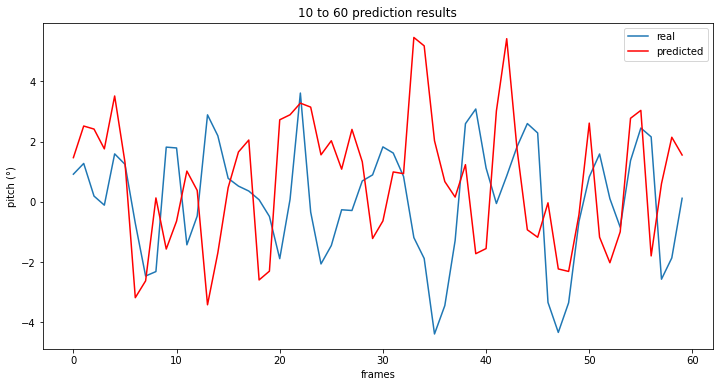

In [51]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(output_sequence[0].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

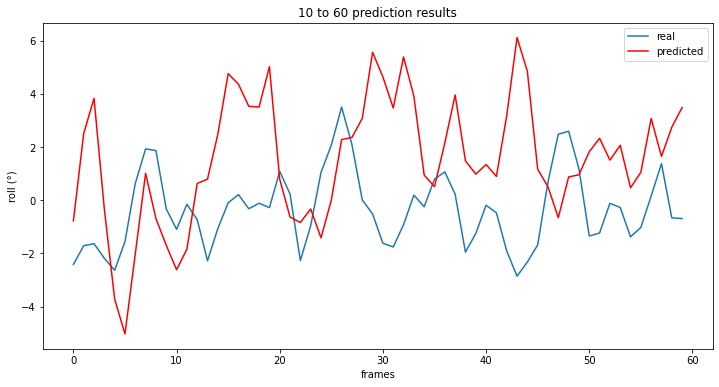

In [52]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(output_sequence[1].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[1].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### Full test loop

In [45]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["input"]
        y_test = batch["output"]

        if CUDA:
            x_test = x_test.cuda()

        output = loaded_model(x_test.squeeze(1))

        # squeeze out batch size which is = 1 for test dataset
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.squeeze(0))

  0%|          | 0/35748 [00:00<?, ?it/s]

In [27]:
predictions[0][0]

tensor([ 0.0147,  0.1523,  0.0925,  0.0758, -0.0384,  0.1151,  0.1270,  0.0880,
         0.0748,  0.0356,  0.0634,  0.0530, -0.0376, -0.0312, -0.0429,  0.0909,
         0.0665,  0.1607,  0.0682,  0.0143,  0.0450, -0.0207,  0.0970,  0.1309,
         0.0573,  0.0508,  0.0726,  0.0511,  0.0374, -0.0860,  0.0311,  0.0721,
        -0.0905, -0.1312, -0.0840,  0.0917,  0.1883,  0.1484,  0.1606,  0.1635,
         0.1777,  0.0830,  0.0719, -0.0077,  0.1542, -0.0077,  0.0230,  0.0277,
         0.0364, -0.0387,  0.0091, -0.1248,  0.0175,  0.0211,  0.1081,  0.0531,
         0.0489,  0.0713, -0.0087, -0.0024])

In [35]:
labels[0][0]

tensor([-0.0037,  0.1525,  0.0912,  0.0933, -0.0128,  0.0950,  0.1625,  0.1036,
         0.0774,  0.0955,  0.0615,  0.1166, -0.1029, -0.0390, -0.0965,  0.1150,
         0.0672,  0.1892,  0.1413,  0.0972,  0.0782, -0.0112,  0.0431,  0.1098,
         0.0810,  0.0346,  0.0441,  0.0603,  0.0499, -0.0585,  0.0075,  0.0952,
        -0.1104, -0.1677, -0.1942,  0.0601,  0.1967,  0.1765,  0.1818,  0.1645,
         0.2538,  0.2093,  0.1261, -0.0085,  0.1973,  0.0156,  0.0242,  0.0590,
         0.1047, -0.0406,  0.0331, -0.1455,  0.0176,  0.0285,  0.1294,  0.1163,
         0.0226,  0.0171, -0.0660,  0.0246])

In [28]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([60]), torch.Size([60]), torch.Size([60]), torch.Size([60]))

### Average loss-per-frame over all datapoints

In [29]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [30]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

  0%|          | 0/35748 [00:00<?, ?it/s]

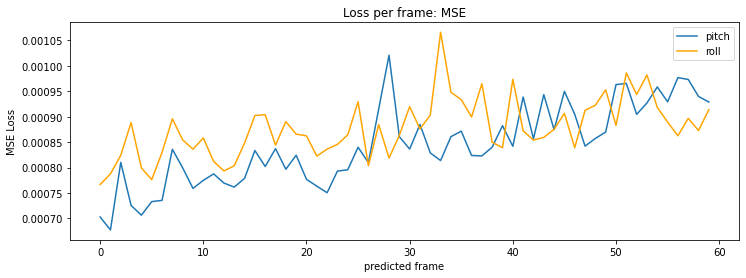

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(pitch_lpf_mse, label='pitch')
plt.plot(roll_lpf_mse, color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('MSE Loss')
plt.title('Loss per frame: MSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-MSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

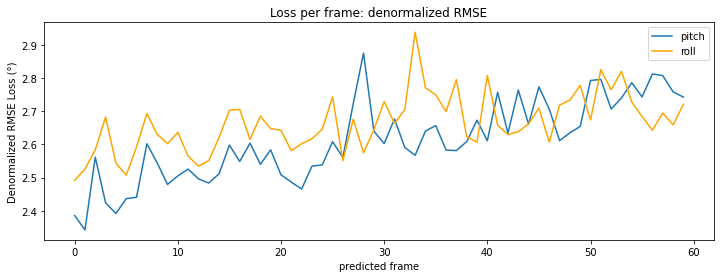

In [ ]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(12, 4))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE Loss (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### MSE results pitch

In [46]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(pitch_label[i], pitch_predictions[i]).item()
    loss0 += criterion(pitch_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Pitch prediction
   MSE: 0.04943
   RMSE: 0.2223
   RMSE denorm: 20.01°
Zero prediction
   MSE 0: 0.00494
   RMSE 0: 0.0703
   RMSE denorm: 6.33°
Improvement on zero prediction:
   MSE delta%: 9.99 %
   RMSE delta%: 31.62 %


### MSE results roll

In [43]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(roll_label[i], roll_predictions[i]).item()
    loss0 += criterion(roll_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.05034
   RMSE: 0.2244
   RMSE denorm: 20.2°
Zero prediction
   MSE 0: 0.00682
   RMSE 0: 0.0826
   RMSE denorm: 7.43°
Improvement on zero prediction:
   MSE delta%: 13.55 %
   RMSE delta%: 36.81 %
